# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: red;"><span style="color: royalblue;">Emotion recognition through facial expression</span></span>

### Artificial Neural Networks and Deep Learning I - Project

Ana Maria Jaramillo

Saghar Ghaffari




The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories:

| categorie  | emotion  |
|:---:|:---|
| 0  | Angry  |
| 1  |  Disgust |
| 2  |  Fear |
| 3  |  Happy |
| 4  |  Sad |
| 5  |  Surprise |
| 6  | Neutral |


In [254]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization , Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop



In [255]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [256]:
#Read the dataset
import pandas as pd
data = pd.read_csv(r"/content/drive/My Drive/ANN/icml_face_data.csv")


In [257]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


### EDA

First we are going to check the missing values of our Data set

In [258]:
data.isnull().sum()

emotion    0
 Usage     0
 pixels    0
dtype: int64

In [259]:
data.columns

Index(['emotion', ' Usage', ' pixels'], dtype='object')

In [260]:
data.columns = ['Emotion','Usage','Pixels']

In [261]:
data['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [262]:
data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [263]:
def plot_emotion_distribution(emotion_labels):
    emotion_counts = emotion_labels.value_counts().sort_index()
    x_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

    plt.bar(x_labels, emotion_counts)
    plt.title('Emotion Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')

    # Remove the grid
    plt.grid(False)

    # Add percentage labels to the bar chart
    total = emotion_labels.shape[0]
    for i, count in enumerate(emotion_counts):
        percentage = (count / total) * 100
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()


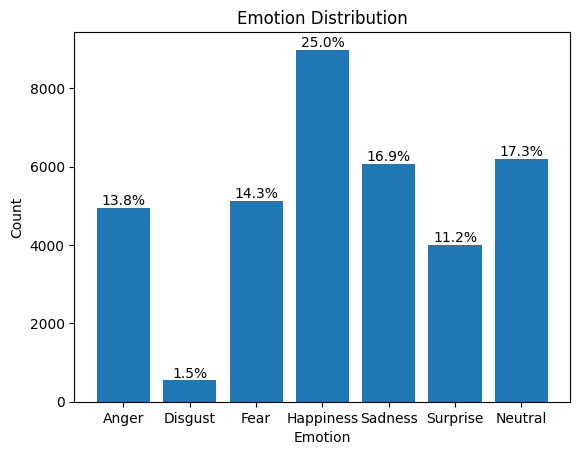

In [264]:
#distribution of the whole set emotions
plot_emotion_distribution(data['Emotion'])

In [265]:

# Count the occurrences of each emotion category
emotion_counts = data['Emotion'].value_counts().sort_index()

# Calculate the percentage of each emotion category
emotion_percentages = (emotion_counts / len(data)) * 100

# Define the emotion labels
emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

# Print the percentages in order from 0 to 6 with corresponding labels
for i in range(len(emotion_labels)):
    emotion_label = emotion_labels[i]
    emotion_percentage = emotion_percentages[i]
    print(f"Emotion {i}: {emotion_label} - {emotion_percentage:.2f}%")


Emotion 0: Anger - 13.80%
Emotion 1: Disgust - 1.52%
Emotion 2: Fear - 14.27%
Emotion 3: Happiness - 25.05%
Emotion 4: Sadness - 16.93%
Emotion 5: Surprise - 11.15%
Emotion 6: Neutral - 17.27%


In [266]:
def plot_emotion_distribution(emotion_labels):
    emotion_counts = emotion_labels.value_counts().sort_index()
    x_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

    plt.bar(x_labels, emotion_counts)
    plt.title('Emotion Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.grid()

    # Add percentage text to each bar
    total_count = len(emotion_labels)
    for i, count in enumerate(emotion_counts):
        percentage = (count / total_count) * 100
        plt.text(i, count, f"{percentage:.2f}%", ha='center', va='bottom')

    plt.show()


In [267]:
sum(data['Emotion']==1)

547

Since the "Disgust" emotion has 1.52% of the whole samples which is 547 from 35887,so makes the distributaon imbalance therefore affects on the model efficiency, we tend to remove it from the samples.

So we have to define our new dataset with out Disgust

In [268]:
data_f = data[data['Emotion'] != 1]  # Remove rows with Emotion value 1 (Disgust)
# Reset the index of the new DataFrame
data_f = data_f.reset_index(drop=True)

# Update the Emotion column labels
data_f.loc[data_f['Emotion'] > 1, 'Emotion'] -= 1

# Define the new emotion labels
emotion_labels = ['Anger', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']



In [269]:
data_f.head()

,Emotion,Usage,Pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,1,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,3,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,5,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [270]:
data_f['Usage'].value_counts()

Training       28273
PrivateTest     3534
PublicTest      3533
Name: Usage, dtype: int64

we will ignore the Usage column Since we decided to do the split randomly


### Data Preparation

Initialize two empty lists image_array and image_label to store the image data and corresponding labels, respectively.
Iterate over each row in the data_f DataFrame using the iterrows() method.
For each row, retrieve the pixel values and emotion label using the column names 'Pixels' and 'Emotion', respectively.
The pixel values are stored as a string separated by spaces. Split the string by spaces using the split() method to obtain individual pixel values.
Convert the pixel values to a NumPy array using np.array() and specify the data type as np.uint8 to ensure the values are interpreted as unsigned 8-bit integers.
Reshape the flattened array of pixel values into a 2D image array with dimensions (48, 48) using the reshape() method.
Append the image array to the image_array list and the corresponding emotion label to the image_label list.
After iterating over all rows, convert the image_array and image_label lists to NumPy arrays using np.array().
Return the image array and label array as a tuple (image_array, image_label).

In [271]:
def prepare_data(data_f):
    image_array = []
    image_label = []

    for _, row in data_f.iterrows():
        pixels = row['Pixels']
        emotion = row['Emotion']

        image = np.array(pixels.split(' '), dtype=np.uint8)
        image = image.reshape((48, 48))

        image_array.append(image)
        image_label.append(emotion)

    return np.array(image_array), np.array(image_label)


### Define training, validation and test data

We decided to instead of using the provided pubic test and private test and training set just, do our split with 80% of whole set to Training and the 10% percent to Validation and 10% percent to test set

In [272]:

data_f_image_array, data_f_image_label = prepare_data(data_f)



In [273]:
from sklearn.model_selection import train_test_split

# Split the data into training and evaluation sets
train_image_array, evaluation_image_array, train_image_label, evaluation_image_label = train_test_split(
    data_f_image_array, data_f_image_label, test_size=0.2, random_state=42)

# Split the evaluation data into validation and test sets
val_image_array, test_image_array, val_image_label, test_image_label = train_test_split(
    evaluation_image_array, evaluation_image_label, test_size=0.5, random_state=42)


I will check for the normalization of the data to make sure that the values are between 0 and 255

In [274]:
train_image_array.max()

255

Reshaping Images Dataframe


First we Reshapes the train_image_array to have a new shape,The first dimension remains the same (number of images in the training set), while the remaining dimensions represent the image size (48x48) and the number of channels (1, indicating grayscale).This reshaping is typically necessary to match the input shape expected by the convolutional neural network (CNN) model.
Converts the data type of train_images from the default integer type to float32.
Divides each pixel value by 255 to normalize the pixel intensities between 0 and 1.
Normalizing the pixel values to the range [0, 1] helps in stabilizing the training process and improving convergence of the neural network.


And we do the same for Validation and Test set

In [275]:
def preprocess_images(images):
    processed_images = images.reshape(images.shape[0], 48, 48, 1).astype('float32') / 255.0
    return processed_images

train_images = preprocess_images(train_image_array)
val_images = preprocess_images(val_image_array)
test_images = preprocess_images(test_image_array)


The purpose of one-hot encoding the target labels is to transform them into a format that can be easily understood by the neural network model. Each label is represented as a binary vector where the index corresponding to the true class is set to 1 and all other indices are set to 0. This allows the model to predict the probability distribution across multiple classes and make a decision based on the class with the highest probability.

By performing one-hot encoding, the model can effectively learn to predict the correct class from a multi-class classification problem. It ensures that the model's output matches the desired format and enables the use of appropriate loss functions, such as categorical cross-entropy, for training the model.

In [276]:
#Encoding target values
def to_categorical(labels, num_classes):
    return np.eye(num_classes)[labels]

train_labels = to_categorical(train_image_label, num_classes=6)
val_labels = to_categorical(val_image_label, num_classes=6)
test_labels = to_categorical(test_image_label, num_classes=6)

Now we prepared our data to build our model, it is time to see 5 examples of each emotion form the train set

In [277]:
def plot_examples(label=0, num_examples=5):
    emotion_labels = ['Anger', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']
    indices = np.where(train_image_label == label)[0]
    selected_indices = random.sample(list(indices), num_examples)

    fig, axs = plt.subplots(1, num_examples, figsize=(25, 12))
    fig.subplots_adjust(hspace=.2, wspace=.2)
    axs = axs.ravel()

    for i, idx in enumerate(selected_indices):
        axs[i].imshow(train_images[idx][:, :, 0], cmap='gray')
        axs[i].set_title(emotion_labels[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

    plt.show()


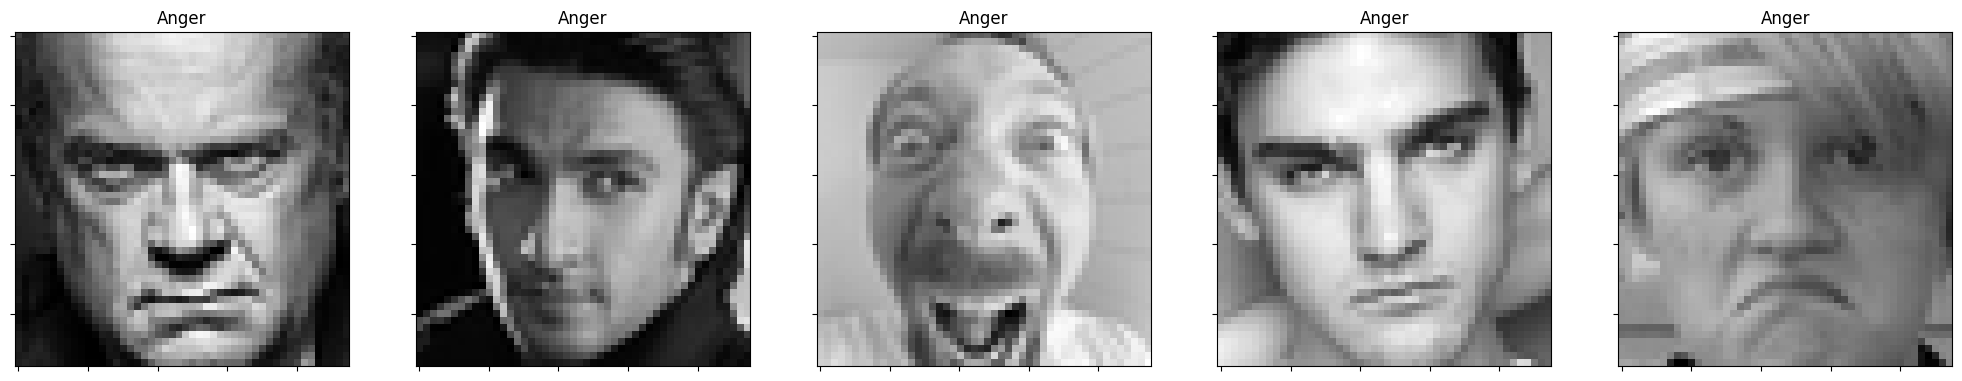

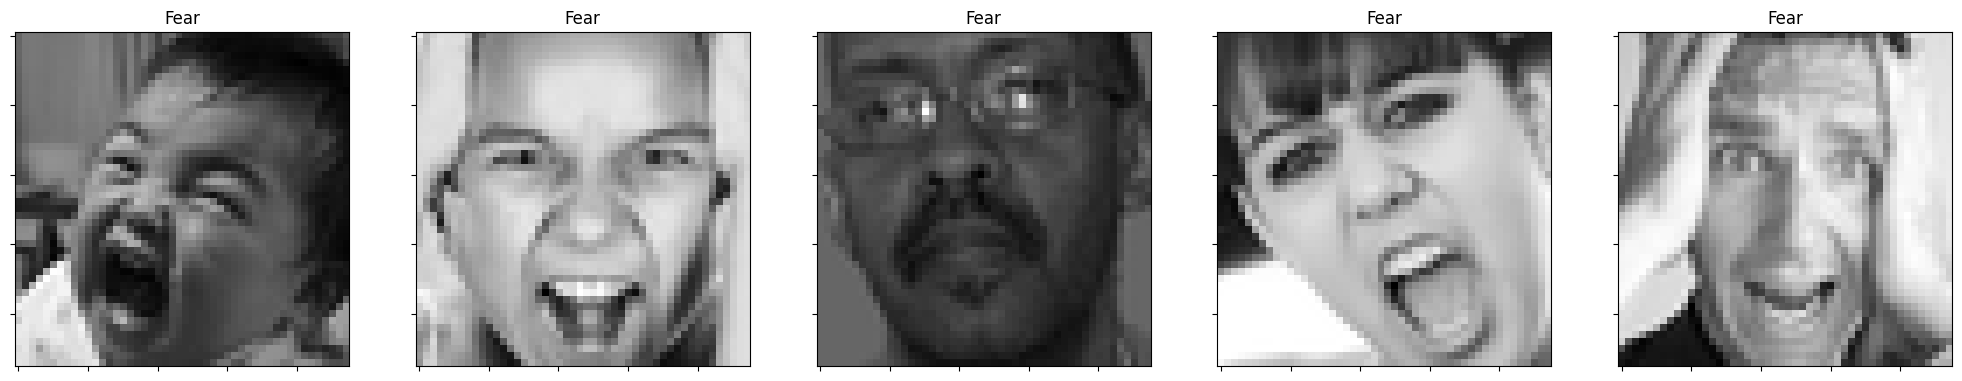

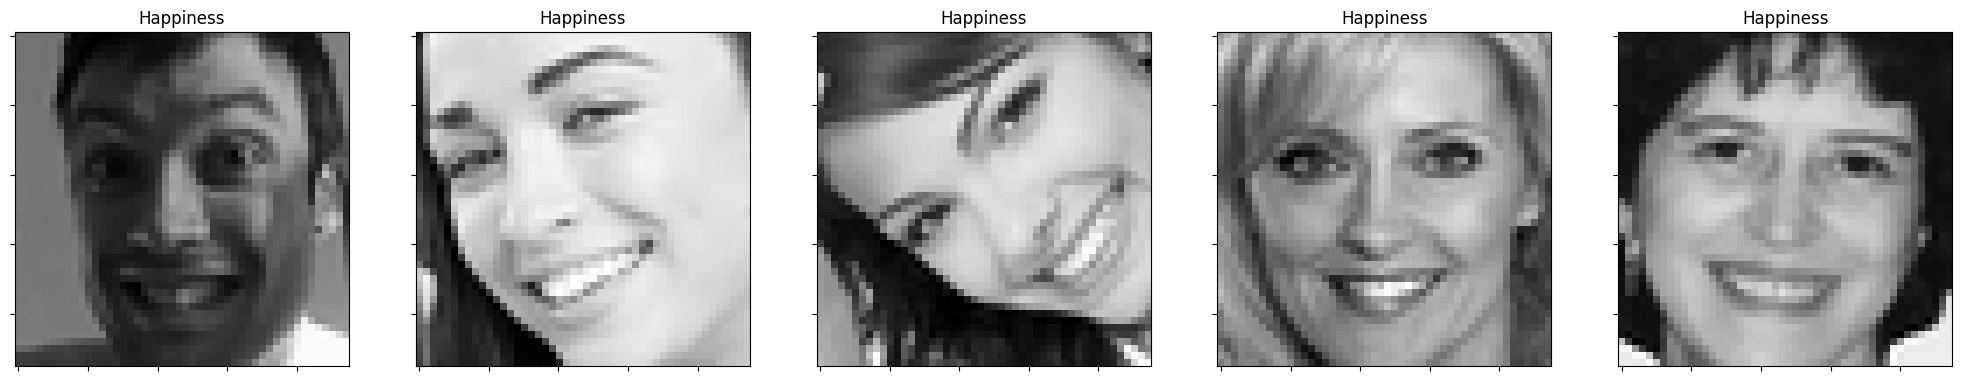

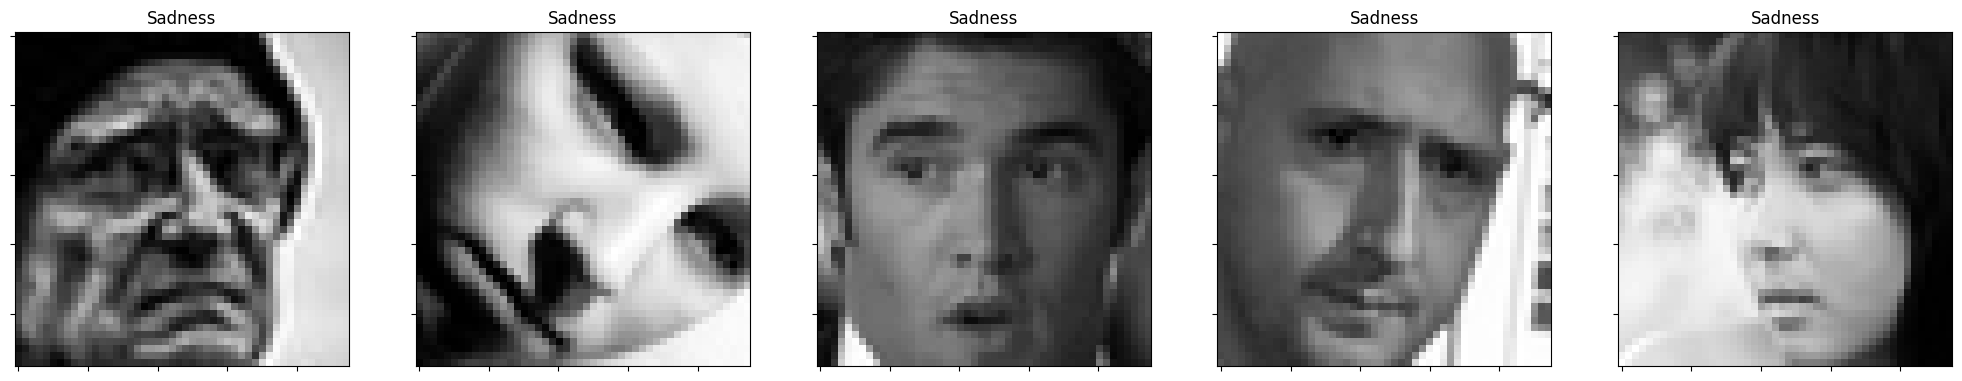

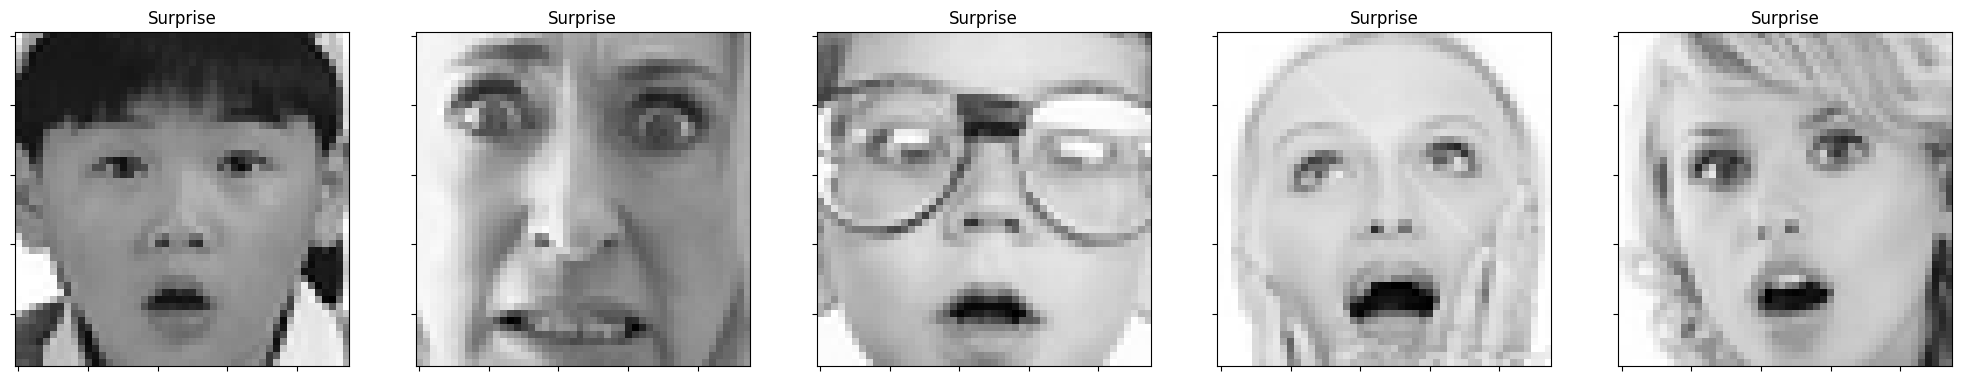

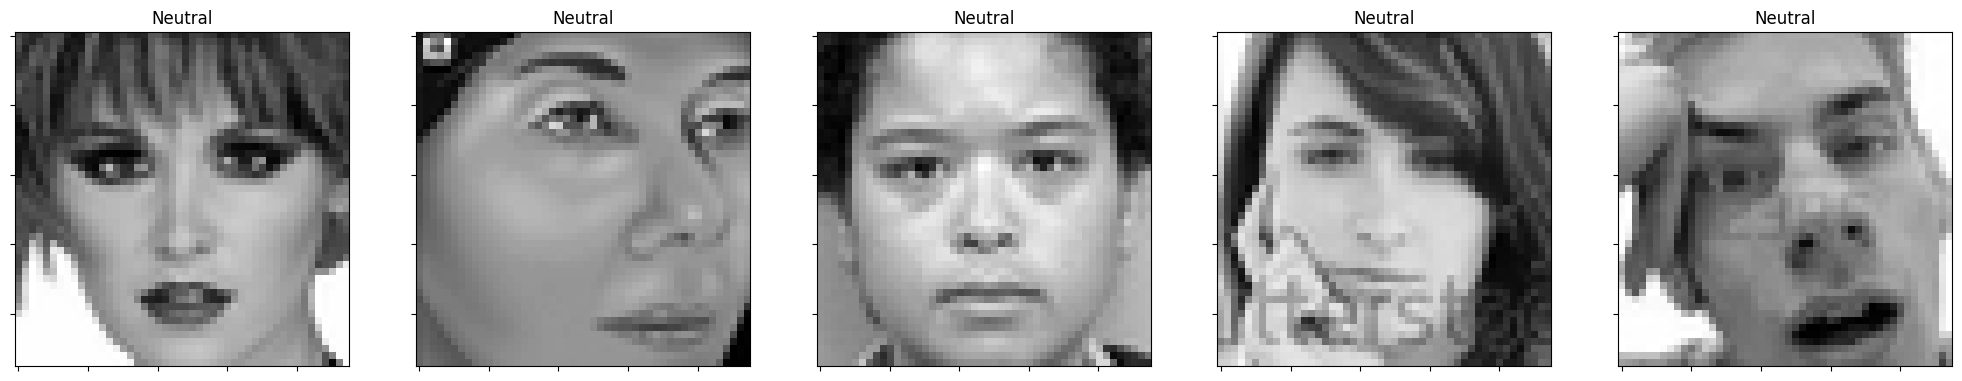

In [278]:
for i in range(0,6):
          plot_examples(label=i)

### Model Building

here are some techniques that are commonly used and have shown promising results in emotion recognition tasks:

Convolutional Neural Networks (CNNs): CNNs are widely used for image-based tasks, including emotion recognition. They are effective in capturing spatial patterns and hierarchical representations from images. CNNs typically consist of convolutional layers, pooling layers, and fully connected layers.
Transfer Learning: Transfer learning involves using pre-trained models that are trained on a large-scale dataset, such as ImageNet. By leveraging the knowledge gained from pre-training, you can use these models as a starting point and fine-tune them on your emotion recognition task. This approach can be useful when you have a limited amount of data.
Data Augmentation: Data augmentation techniques, such as rotation, translation, scaling, and flipping, can be applied to increase the diversity of the training data. This helps the model generalize better and reduces overfitting. Data augmentation is particularly useful when the available dataset is limited.
Ensemble Learning: Ensemble learning involves combining multiple models to make predictions. Different models with varied architectures or training techniques can be trained independently, and their predictions can be combined using voting or averaging. Ensemble learning can improve the overall performance and robustness of the model.


the further variation are going to be used for our models

1. we will use CNN with 3 different archtecture

2. we will use data augmentation over the best model

3. we will tune the hyper parameters regarding to achieve better result

1. we initialize a sequential model, which allows us to build the model layer by layer in a sequential manner.
2. add a convolutional layer with 32 filters, each of size 3x3. The activation function used is ReLU, which introduces non-linearity. The input_shape parameter specifies the shape of the input images, which is (48, 48, 1) indicating a grayscale image of size 48x48.
3. add a batch normalization layer. Batch normalization normalizes the input of each mini-batch, which helps in stabilizing and accelerating the training process.
4. add a max pooling layer with a pool size of 2x2. Max pooling reduces the spatial dimensions of the input, helping to extract important features while reducing computational complexity.
5. This adds another convolutional layer with 64 filters of size 3x3 and ReLU activation.
6. Another batch normalization layer is added for normalization.
7. Another max pooling layer is added.
8. This adds another convolutional layer with 128 filters of size 3x3 and ReLU activation.
9. Another batch normalization layer is added.
10. Another max pooling layer is added.
11. flatten the output from the previous layer into a 1D array, preparing it for the fully connected layers.
12. add a fully connected layer with 128 units and ReLU activation.
13. Dropout is applied to the previous layer with a rate of 0.5. Dropout randomly sets a fraction of input units to 0 during training, which helps prevent overfitting.

Regularization methods such as dropout and weight regularization can prevent overfitting. In our current model, we already have a dropout layer with a rate of 0.5, which helps to randomly drop out connections during training. We may try adjusting the dropout rate or adding more dropout layers to further regularize the model.

14. The final fully connected layer is added with 6 units (representing the 6 emotions excluding 'disgust') and softmax activation. Softmax ensures that the output probabilities sum up to 1, allowing us to interpret the outputs as class probabilities.
The choice of hyperparameters depends on the specific problem and dataset. Here are some reasons behind using these hyperparameters:

Convolutional layers with increasing filter sizes: The initial layers extract low-level features, while the deeper layers capture more abstract and higher-level features.
ReLU activation: ReLU is commonly used as an activation function in CNNs since it introduces non-linearity, allowing the network to learn complex representations.
Batch normalization: Normalizing the inputs of each mini-batch helps in stabilizing the learning process, improving the speed of convergence and generalization performance.
Max pooling: Reducing the spatial dimensions through max pooling helps in downsampling the input, extracting important features while reducing the computational complexity.
Dropout: Applying dropout regularizes the model by preventing overfitting. It randomly sets a fraction of input units

Model Compilation:
The model is compiled with the Adam optimizer and the loss function is set to categorical cross-entropy, which is suitable for multiclass classification.
The chosen metric for evaluation is accuracy.
Model Training:
The fit function is called on the model to train it.
train_images and train_labels are the training data, where train_images are the input images and train_labels are the corresponding labels.
The batch_size is set to 32, which means the model will be trained on batches of 32 samples at a time.
steps_per_epoch is calculated as the number of training images divided by the batch size, which determines the number of steps per epoch.
The epochs parameter defines the number of times the entire training dataset will be iterated.
The validation_data parameter is set to (val_images, val_labels) to evaluate the model's performance on the validation set during training.
The verbose parameter is set to 2, which provides a detailed progress bar during training.

In [279]:

# Build the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))  # 6 emotions excluding 'disgust'


In [280]:

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [281]:

# Train the model
history = model.fit(train_images, train_labels, batch_size=32,
                    steps_per_epoch=len(train_images) // 32, epochs=50,
                    validation_data=(val_images, val_labels),verbose=2)


Epoch 1/50
883/883 - 7s - loss: 1.6895 - accuracy: 0.3112 - val_loss: 1.4988 - val_accuracy: 0.4018 - 7s/epoch - 8ms/step
Epoch 2/50
883/883 - 4s - loss: 1.4912 - accuracy: 0.3956 - val_loss: 1.4166 - val_accuracy: 0.4601 - 4s/epoch - 5ms/step
Epoch 3/50
883/883 - 4s - loss: 1.4131 - accuracy: 0.4323 - val_loss: 1.3947 - val_accuracy: 0.4372 - 4s/epoch - 5ms/step
Epoch 4/50
883/883 - 4s - loss: 1.3476 - accuracy: 0.4670 - val_loss: 1.2878 - val_accuracy: 0.5006 - 4s/epoch - 5ms/step
Epoch 5/50
883/883 - 4s - loss: 1.2867 - accuracy: 0.4925 - val_loss: 1.3419 - val_accuracy: 0.4723 - 4s/epoch - 5ms/step
Epoch 6/50
883/883 - 4s - loss: 1.2445 - accuracy: 0.5140 - val_loss: 1.2272 - val_accuracy: 0.5314 - 4s/epoch - 5ms/step
Epoch 7/50
883/883 - 4s - loss: 1.1919 - accuracy: 0.5310 - val_loss: 1.2317 - val_accuracy: 0.5340 - 4s/epoch - 4ms/step
Epoch 8/50
883/883 - 4s - loss: 1.1498 - accuracy: 0.5496 - val_loss: 1.2877 - val_accuracy: 0.5201 - 4s/epoch - 5ms/step
Epoch 9/50
883/883 - 4s 

In [282]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

111/111 [==============================] - 0s 3ms/step - loss: 2.3560 - accuracy: 0.5569
test caccuracy: 0.5568760633468628


In [283]:
pred_test_labels = model.predict(test_images)

111/111 [==============================] - 0s 2ms/step


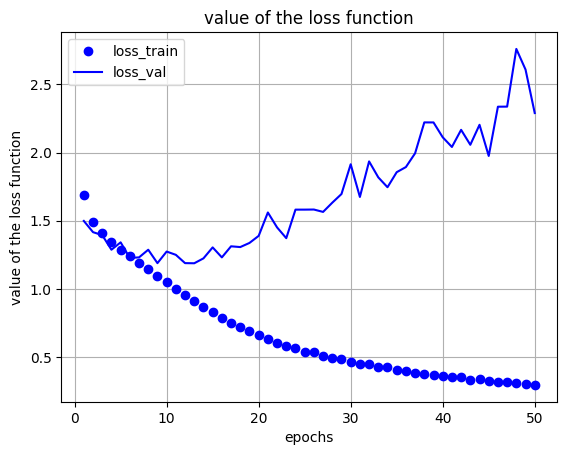

In [284]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

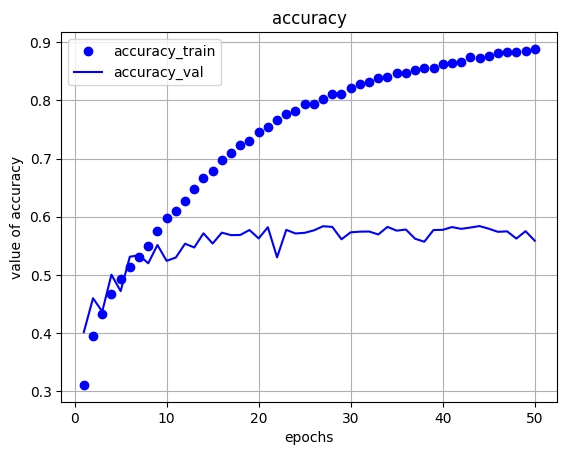

In [285]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

In [286]:

def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """Function to plot the image and compare the prediction results with the label"""


    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

    # Plot the image
    axs[0].imshow(test_image_array[image_number], cmap='gray')
    axs[0].set_title(emotion_labels[test_image_label[image_number]])
    axs[0].axis('off')

    # Plot the predicted labels
    axs[1].bar(emotion_labels, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].set_xlabel('Emotion')
    axs[1].set_ylabel('Probability')
    axs[1].set_title('Predicted Emotion Probabilities')
    axs[1].grid(axis='y')

    plt.tight_layout()
    plt.show()


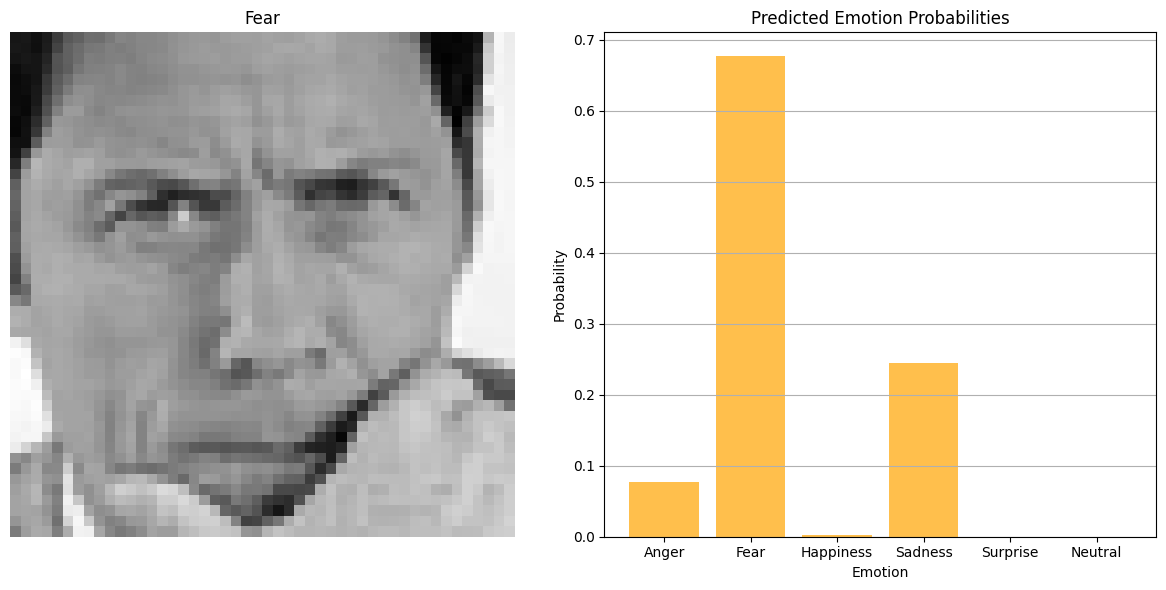

In [287]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 105)

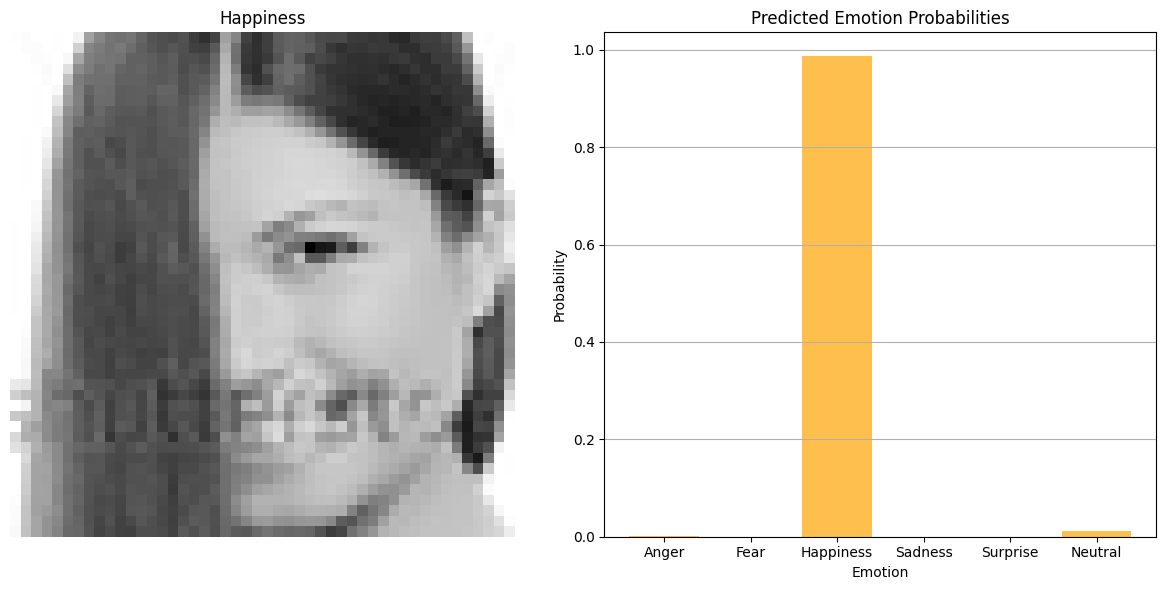

In [288]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 3500)

### Analyse of Wrong Predictions for model 1

In [289]:
def plot_confusion_matrix(conf_mat, class_names, normalize=False, figsize=(8, 8), title="Confusion Matrix"):


    if normalize:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(conf_mat.shape[1]),
           yticks=np.arange(conf_mat.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()


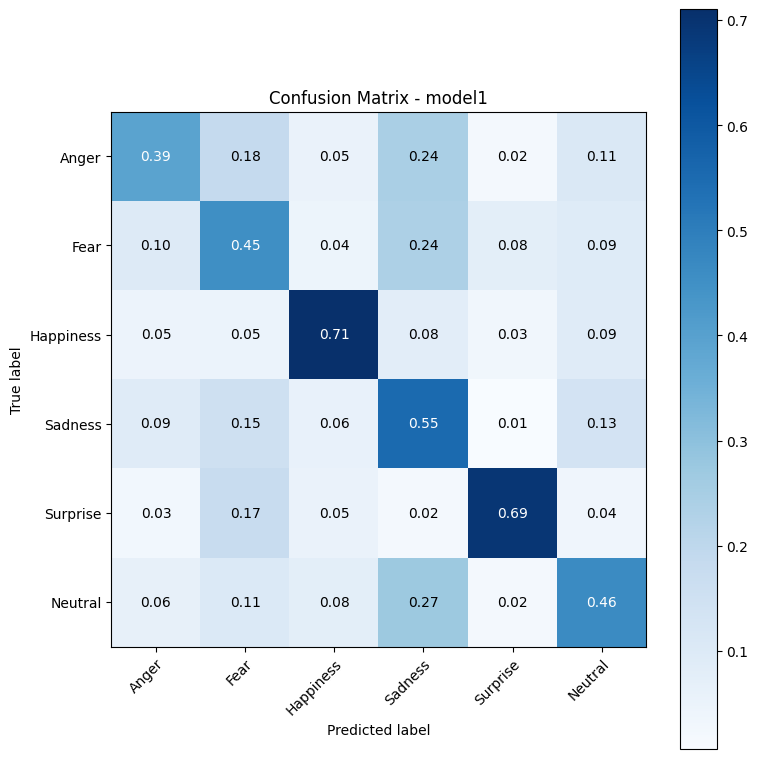

In [290]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))
emotion_labels = ['Anger', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

plot_confusion_matrix(conf_mat=conf_mat,
                      class_names=emotion_labels,
                      normalize=True,
                      figsize=(8, 8),
                      title="Confusion Matrix - model1")


### Model building with data Augmentation


In this enhanced model, the following changes have been made:


The first layer is a Conv2D layer with 32 filters, a kernel size of (3, 3), and a ReLU activation function. It takes input images of size (48, 48, 1) (grayscale images).
The second layer is another Conv2D layer with 32 filters and a (3, 3) kernel size, followed by a ReLU activation.
A BatchNormalization layer is added to normalize the activations of the previous layer.
The next two layers are Conv2D layers with 64 filters, (3, 3) kernel size, and ReLU activation.
A MaxPooling2D layer with a pool size of (2, 2) is added to downsample the spatial dimensions.
The output of the MaxPooling2D layer is flattened using Flatten.
A fully connected Dense layer with 256 units and ReLU activation is added.
A Dropout layer with a rate of 0.5 is used for regularization.
The final Dense layer consists of 6 units with a softmax activation function, representing the output classes.



In [291]:



# Define the model architecture
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(6, activation='softmax'))

# Compile the model
model2.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history2 = model2.fit(train_images, train_labels, batch_size=64,
                    steps_per_epoch=len(train_images) // 64, epochs=50,
                    validation_data=(val_images, val_labels),verbose=2)


Epoch 1/50
441/441 - 10s - loss: 1.5922 - accuracy: 0.3503 - val_loss: 1.4437 - val_accuracy: 0.4242 - 10s/epoch - 23ms/step
Epoch 2/50
441/441 - 8s - loss: 1.3454 - accuracy: 0.4678 - val_loss: 1.3057 - val_accuracy: 0.4805 - 8s/epoch - 18ms/step
Epoch 3/50
441/441 - 8s - loss: 1.2174 - accuracy: 0.5271 - val_loss: 1.2292 - val_accuracy: 0.5235 - 8s/epoch - 18ms/step
Epoch 4/50
441/441 - 8s - loss: 1.0935 - accuracy: 0.5788 - val_loss: 1.2222 - val_accuracy: 0.5209 - 8s/epoch - 18ms/step
Epoch 5/50
441/441 - 8s - loss: 0.9477 - accuracy: 0.6354 - val_loss: 1.2298 - val_accuracy: 0.5405 - 8s/epoch - 18ms/step
Epoch 6/50
441/441 - 8s - loss: 0.8058 - accuracy: 0.6957 - val_loss: 1.3144 - val_accuracy: 0.5430 - 8s/epoch - 18ms/step
Epoch 7/50
441/441 - 8s - loss: 0.6766 - accuracy: 0.7451 - val_loss: 1.3497 - val_accuracy: 0.5416 - 8s/epoch - 18ms/step
Epoch 8/50
441/441 - 8s - loss: 0.5777 - accuracy: 0.7832 - val_loss: 1.4411 - val_accuracy: 0.5422 - 8s/epoch - 18ms/step
Epoch 9/50
441

In [292]:
# Evaluate the model
test_loss2, test_acc2 = model2.evaluate(test_images, test_labels)
print("Test Accuracy:", test_acc2)

111/111 [==============================] - 0s 4ms/step - loss: 3.4609 - accuracy: 0.5314
Test Accuracy: 0.5314091444015503


In [293]:
pred_test_labels2 = model2.predict(test_images)

111/111 [==============================] - 0s 3ms/step


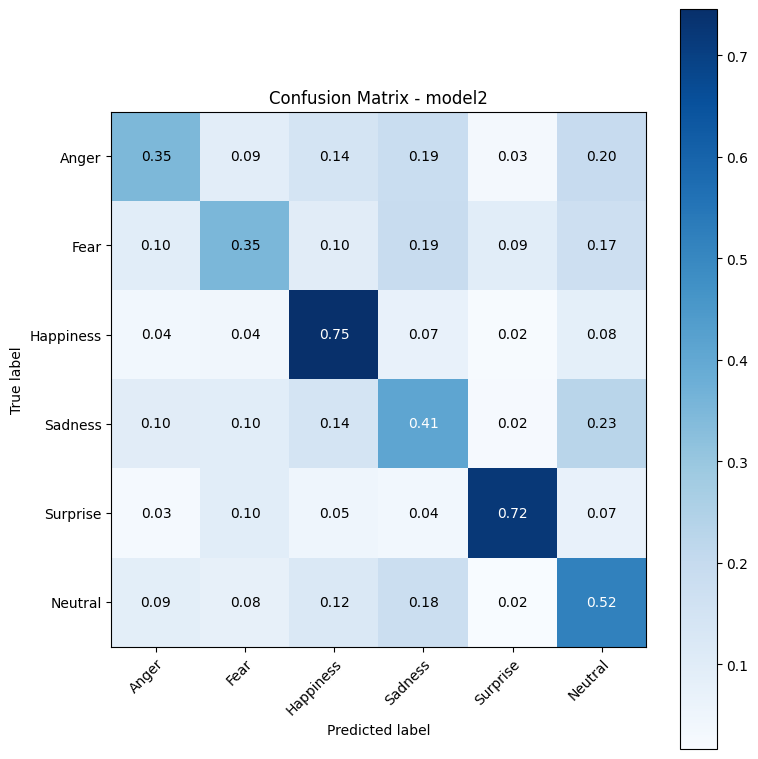

In [294]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels2.argmax(axis=1))
emotion_labels = ['Anger', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

plot_confusion_matrix(conf_mat=conf_mat,
                      class_names=emotion_labels,
                      normalize=True,
                      figsize=(8, 8),
                      title="Confusion Matrix - model2")

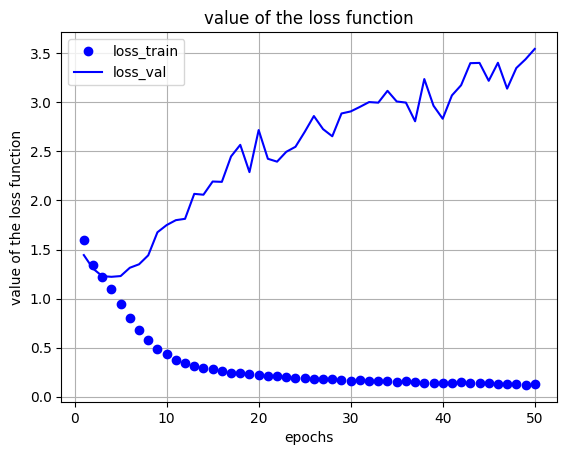

In [295]:
loss = history2.history['loss']
loss_val = history2.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

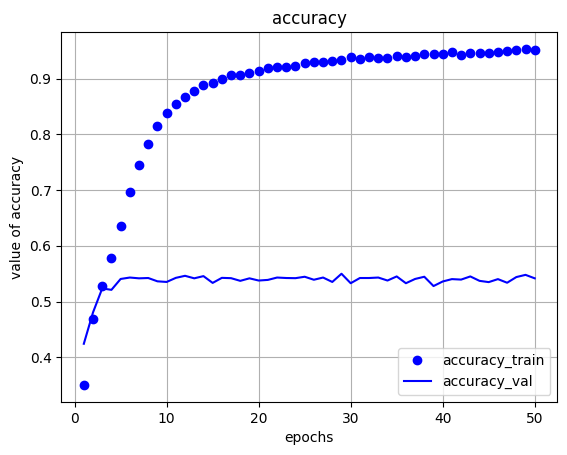

In [296]:
acc = history2.history['accuracy']
acc_val = history2.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

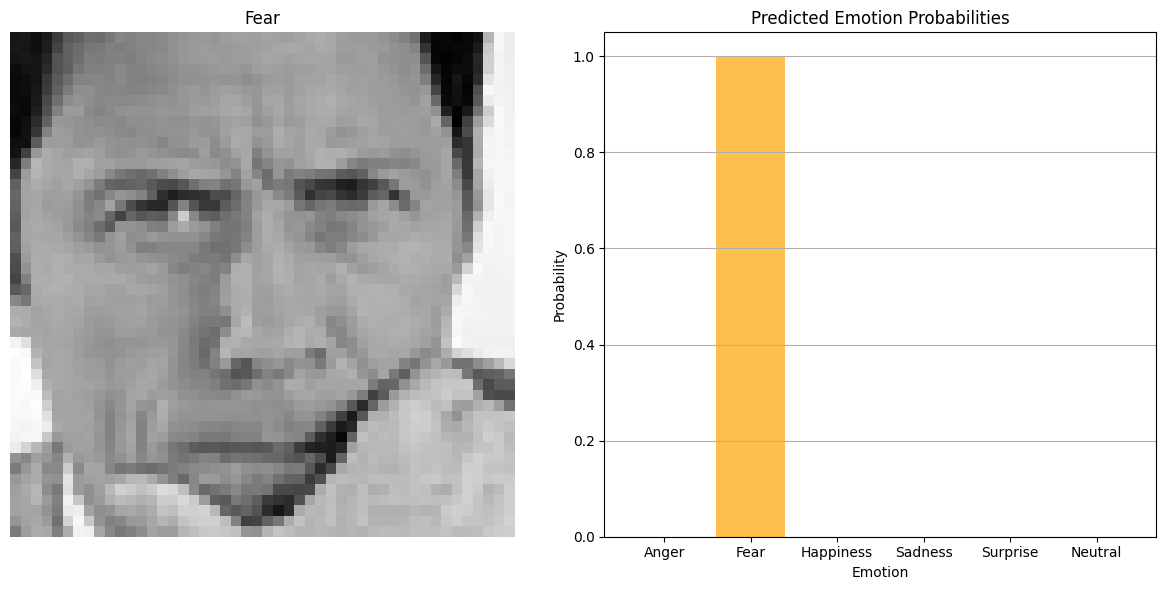

In [297]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels2, 105)

### Model3 - More complex

The first layer is a Conv2D layer with 64 filters, a kernel size of (3, 3), and a ReLU activation function. It takes input images of size (48, 48, 1).
The second layer is another Conv2D layer with 64 filters and a (3, 3) kernel size, followed by a ReLU activation.
A MaxPooling2D layer with a pool size of (2, 2) is added to downsample the spatial dimensions.
A Dropout layer with a rate of 0.25 is added for regularization.
The next two layers follow a similar pattern: Conv2D layers with 128 filters and (3, 3) kernel size, followed by ReLU activations, and then a MaxPooling2D layer with a (2, 2) pool size. Each of these layers is followed by a Dropout layer with a rate of 0.25.
The next two layers again follow the same pattern: Conv2D layers with 256 filters and (3, 3) kernel size, ReLU activations, and MaxPooling2D layers with (2, 2) pool size. Each is followed by a Dropout layer with a rate of 0.25.
The output of the last MaxPooling2D layer is flattened using Flatten.
A fully connected Dense layer with 512 units and ReLU activation is added.
A Dropout layer with a rate of 0.5 is used for regularization.
The final Dense layer consists of 6 units with a softmax activation function, representing the output classes.

In [299]:
model3 = Sequential()

model3.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Flatten())

model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(6, activation='softmax'))

# Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history3 = model3.fit(train_images, train_labels, batch_size=128,
                    steps_per_epoch=len(train_images) // 128, epochs=50,
                    validation_data=(val_images, val_labels),verbose=2)


Epoch 1/50
220/220 - 13s - loss: 1.7632 - accuracy: 0.2516 - val_loss: 1.7549 - val_accuracy: 0.2626 - 13s/epoch - 61ms/step
Epoch 2/50
220/220 - 10s - loss: 1.7461 - accuracy: 0.2564 - val_loss: 1.6680 - val_accuracy: 0.2895 - 10s/epoch - 46ms/step
Epoch 3/50
220/220 - 10s - loss: 1.5736 - accuracy: 0.3579 - val_loss: 1.4461 - val_accuracy: 0.4154 - 10s/epoch - 47ms/step
Epoch 4/50
220/220 - 10s - loss: 1.3795 - accuracy: 0.4542 - val_loss: 1.2868 - val_accuracy: 0.4875 - 10s/epoch - 47ms/step
Epoch 5/50
220/220 - 10s - loss: 1.2685 - accuracy: 0.5054 - val_loss: 1.1974 - val_accuracy: 0.5331 - 10s/epoch - 47ms/step
Epoch 6/50
220/220 - 10s - loss: 1.2049 - accuracy: 0.5322 - val_loss: 1.1378 - val_accuracy: 0.5563 - 10s/epoch - 47ms/step
Epoch 7/50
220/220 - 10s - loss: 1.1621 - accuracy: 0.5486 - val_loss: 1.1423 - val_accuracy: 0.5614 - 10s/epoch - 47ms/step
Epoch 8/50
220/220 - 10s - loss: 1.1218 - accuracy: 0.5661 - val_loss: 1.0916 - val_accuracy: 0.5809 - 10s/epoch - 47ms/step


In [304]:
# Evaluate the model
test_loss3, test_acc3 = model3.evaluate(test_images, test_labels)
print("Test Accuracy:", test_acc3)

111/111 [==============================] - 1s 6ms/step - loss: 1.1383 - accuracy: 0.5611
Test Accuracy: 0.5611205697059631


In [301]:
pred_test_labels3 = model3.predict(test_images)

111/111 [==============================] - 0s 3ms/step


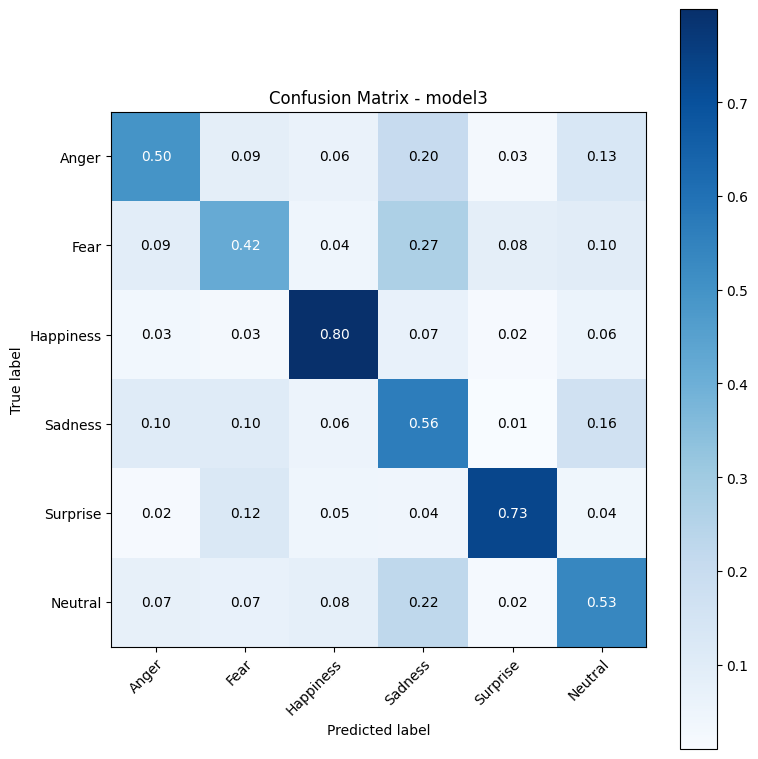

In [305]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels3.argmax(axis=1))
emotion_labels = ['Anger', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

plot_confusion_matrix(conf_mat=conf_mat,
                      class_names=emotion_labels,
                      normalize=True,
                      figsize=(8, 8),
                      title="Confusion Matrix - model3")

Since the 3rd Model got a better confusion matrix so We will tune the hyper parameters on this model and use other technique on it

### Adding Data Augmentation




Data augmentation is a technique used to artificially increase the diversity and size of the training dataset by applying various random transformations to the existing images. We also change the Architecture of the model
The parameters used in the ImageDataGenerator specify different types of transformations that can be applied to the images. Here's a brief explanation of each parameter:

rotation_range: Specifies the range of random rotation angles (in degrees) that can be applied to the images. By setting it to 20, the images can be randomly rotated up to 20 degrees clockwise or counterclockwise.
width_shift_range and height_shift_range: Specify the range of horizontal and vertical shifts that can be applied to the images. These parameters define the maximum proportion of the total width or height by which the image can be shifted horizontally or vertically. In this case, the images can be randomly shifted up to 20% of their width or height.
shear_range: Specifies the range of shearing transformations that can be applied to the images. Shearing involves shifting one part of the image along a direction while keeping the other part fixed. This parameter defines the maximum shear angle in degrees.
zoom_range: Specifies the range of random zooming that can be applied to the images. This parameter defines the maximum zoom level, where a value of 0.2 means the images can be zoomed in or out by up to 20%.
horizontal_flip: Specifies whether horizontal flipping should be applied to the images. If set to True, the images can be randomly flipped horizontally.
By using data augmentation, the model is exposed to a greater variety of training examples, which helps improve its ability to generalize and perform well on unseen data. It introduces variations in the training data, making the model more robust to different orientations, positions, and scales of the input images. This can help prevent overfitting and improve the model's performance and ability to handle real-world scenarios with diverse image conditions.

In this code we also used early stopping to avoid overfitting

In [329]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
# Compile the model
model3.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history4= model3.fit(datagen.flow(train_images, train_labels, batch_size=128),
          steps_per_epoch=len(train_images) // 128,
          epochs=100,
          validation_data=(val_images, val_labels),
          callbacks=[early_stopping],
          verbose=2)

Epoch 1/100
220/220 - 14s - loss: 1.1599 - accuracy: 0.5583 - val_loss: 0.9928 - val_accuracy: 0.6180 - 14s/epoch - 66ms/step
Epoch 2/100
220/220 - 11s - loss: 1.1513 - accuracy: 0.5605 - val_loss: 0.9767 - val_accuracy: 0.6310 - 11s/epoch - 51ms/step
Epoch 3/100
220/220 - 11s - loss: 1.1518 - accuracy: 0.5607 - val_loss: 0.9801 - val_accuracy: 0.6174 - 11s/epoch - 50ms/step
Epoch 4/100
220/220 - 11s - loss: 1.1516 - accuracy: 0.5586 - val_loss: 0.9725 - val_accuracy: 0.6214 - 11s/epoch - 51ms/step
Epoch 5/100
220/220 - 11s - loss: 1.1442 - accuracy: 0.5655 - val_loss: 0.9805 - val_accuracy: 0.6302 - 11s/epoch - 50ms/step
Epoch 6/100
220/220 - 11s - loss: 1.1411 - accuracy: 0.5662 - val_loss: 0.9748 - val_accuracy: 0.6321 - 11s/epoch - 51ms/step
Epoch 7/100
220/220 - 11s - loss: 1.1469 - accuracy: 0.5615 - val_loss: 0.9717 - val_accuracy: 0.6239 - 11s/epoch - 50ms/step
Epoch 8/100
220/220 - 11s - loss: 1.1366 - accuracy: 0.5680 - val_loss: 0.9746 - val_accuracy: 0.6228 - 11s/epoch - 51

In [330]:
test_loss4, test_acc4 = model3.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc4)

111/111 [==============================] - 1s 6ms/step - loss: 0.9935 - accuracy: 0.6324
test caccuracy: 0.6324278712272644


In [331]:
pred_test_labels4 = model3.predict(test_images)

111/111 [==============================] - 1s 4ms/step


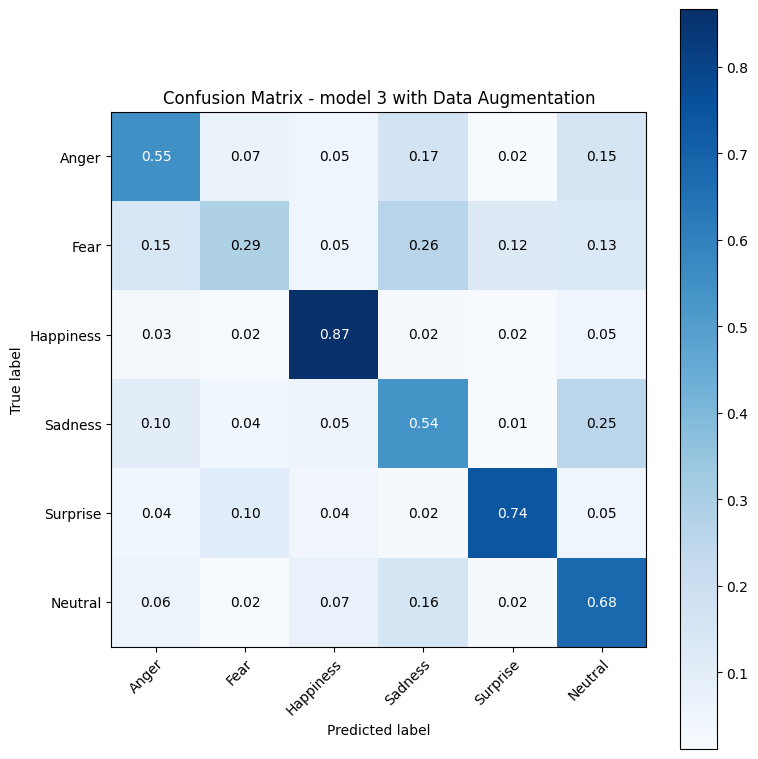

In [332]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels4.argmax(axis=1))
emotion_labels = ['Anger', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

plot_confusion_matrix(conf_mat=conf_mat,
                      class_names=emotion_labels,
                      normalize=True,
                      figsize=(8, 8),
                      title="Confusion Matrix - model 3 with Data Augmentation")

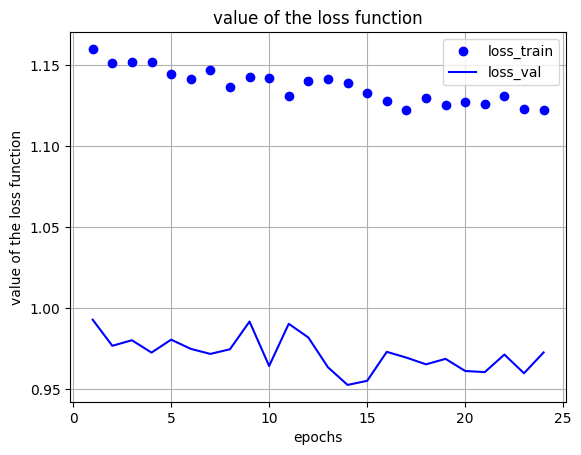

In [333]:
loss = history4.history['loss']
loss_val = history4.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

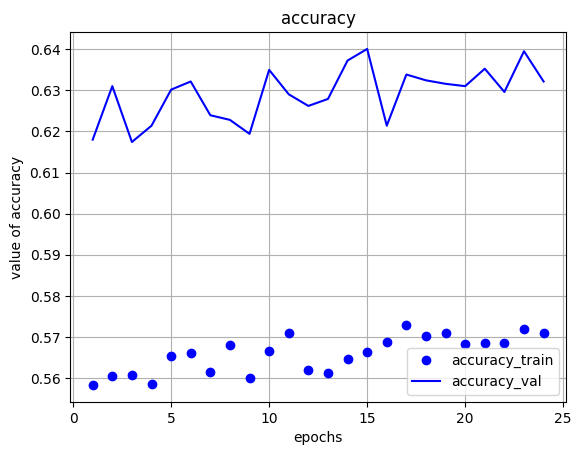

In [334]:
acc = history4.history['accuracy']
acc_val = history4.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

### Add kernel regularization, setting learning rate for Adam optimizer

we keep using archtecture of model 3 for tuning hyper parameters, Since Data Augmentation did not perform well

In this model we have used l2 regularization for the kernel on the Dense layer,Regularization is a technique used to prevent overfitting in the model. In this case, regularizers.l2(0.001) applies L2 regularization with a regularization strength of 0.001. L2 regularization adds a penalty term to the loss function that encourages smaller weight values, thus preventing the model from relying too much on any single feature.
We also tunned the ADAM activation for 0.001 learning rate, The learning rate is a hyperparameter that determines the step size at which the optimizer updates the model weights during training. It controls how quickly or slowly the model learns from the training data. A smaller learning rate means slower but more precise updates, while a larger learning rate means faster but potentially less precise updates. In this case, the learning rate is set to 0.001, which is a commonly used value.

In [335]:

model5 = Sequential()
model5.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model5.add(Conv2D(64, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))

model5.add(Conv2D(128, (3, 3), activation='relu'))
model5.add(Conv2D(128, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))

model5.add(Conv2D(256, (3, 3), activation='relu'))
model5.add(Conv2D(256, (3, 3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))

model5.add(Flatten())

model5.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model5.add(Dropout(0.5))

model5.add(Dense(6, activation='softmax'))



# Compile the model
model5.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the model
history5 = model5.fit(train_images, train_labels, batch_size=128,
                    steps_per_epoch=len(train_images) // 128, epochs=100,
                    validation_data=(val_images, val_labels),
                      callbacks=[early_stopping],verbose=2)

Epoch 1/100
220/220 - 13s - loss: 1.8362 - accuracy: 0.2610 - val_loss: 1.6832 - val_accuracy: 0.3087 - 13s/epoch - 60ms/step
Epoch 2/100
220/220 - 10s - loss: 1.5741 - accuracy: 0.3687 - val_loss: 1.4213 - val_accuracy: 0.4440 - 10s/epoch - 44ms/step
Epoch 3/100
220/220 - 10s - loss: 1.4000 - accuracy: 0.4601 - val_loss: 1.3062 - val_accuracy: 0.4960 - 10s/epoch - 45ms/step
Epoch 4/100
220/220 - 10s - loss: 1.3003 - accuracy: 0.5043 - val_loss: 1.2440 - val_accuracy: 0.5308 - 10s/epoch - 45ms/step
Epoch 5/100
220/220 - 10s - loss: 1.2445 - accuracy: 0.5301 - val_loss: 1.1949 - val_accuracy: 0.5535 - 10s/epoch - 45ms/step
Epoch 6/100
220/220 - 10s - loss: 1.1934 - accuracy: 0.5551 - val_loss: 1.1654 - val_accuracy: 0.5688 - 10s/epoch - 45ms/step
Epoch 7/100
220/220 - 10s - loss: 1.1558 - accuracy: 0.5710 - val_loss: 1.1512 - val_accuracy: 0.5806 - 10s/epoch - 45ms/step
Epoch 8/100
220/220 - 10s - loss: 1.1171 - accuracy: 0.5945 - val_loss: 1.1045 - val_accuracy: 0.5996 - 10s/epoch - 45

In [336]:
test_loss5, test_acc5 = model5.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc5)

111/111 [==============================] - 1s 6ms/step - loss: 1.1414 - accuracy: 0.5900
test caccuracy: 0.5899830460548401


In [337]:
pred_test_labels5 = model5.predict(test_images)

111/111 [==============================] - 1s 4ms/step


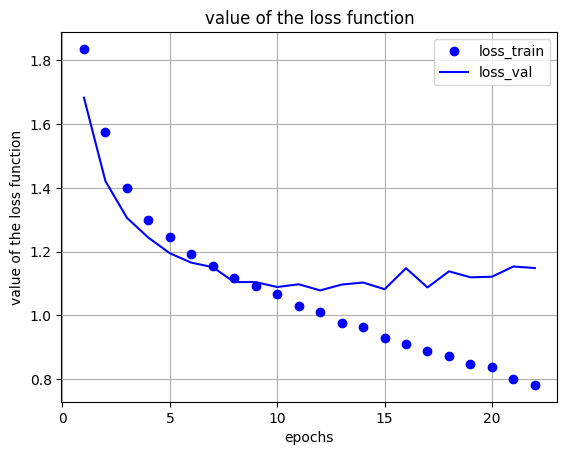

In [338]:
loss = history5.history['loss']
loss_val = history5.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

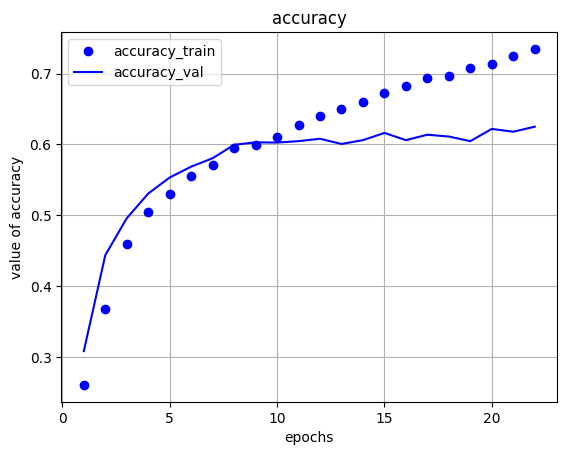

In [339]:
acc = history5.history['accuracy']
acc_val = history5.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

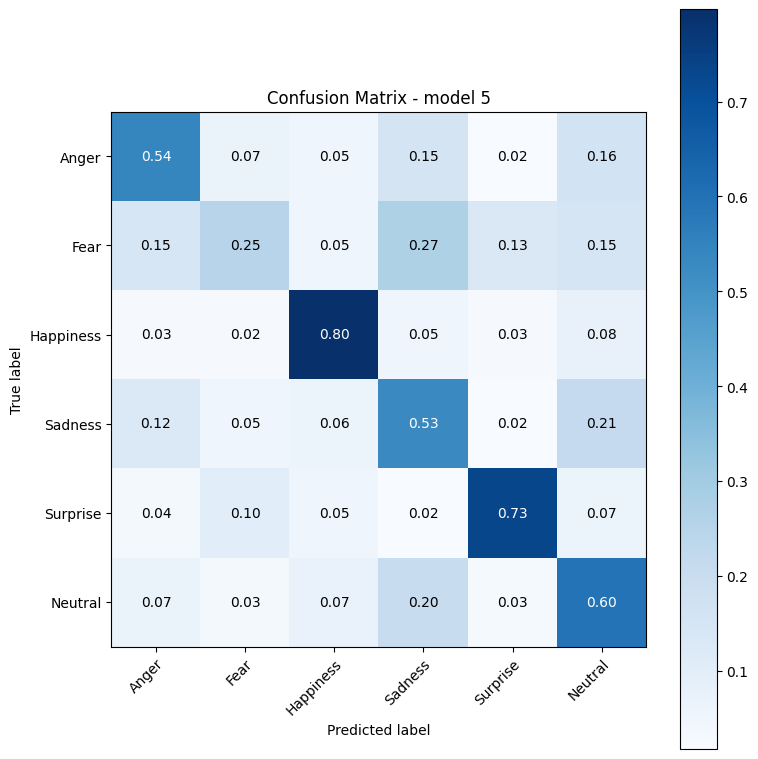

In [340]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels5.argmax(axis=1))
emotion_labels = ['Anger', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

plot_confusion_matrix(conf_mat=conf_mat,
                      class_names=emotion_labels,
                      normalize=True,
                      figsize=(8, 8),
                      title="Confusion Matrix - model 5")

### RMSprop optimization

In this model we keep using model5 with RMSprop as optimiser in compiler


In [341]:



# Compile the model
model5.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the model
history6 = model5.fit(train_images, train_labels, batch_size=128,
                    steps_per_epoch=len(train_images) // 128, epochs=100,
                    validation_data=(val_images, val_labels),
                      callbacks=[early_stopping],verbose=2)


Epoch 1/100
220/220 - 12s - loss: 0.9859 - accuracy: 0.6467 - val_loss: 1.0744 - val_accuracy: 0.6092 - 12s/epoch - 55ms/step
Epoch 2/100
220/220 - 10s - loss: 0.9421 - accuracy: 0.6634 - val_loss: 1.0809 - val_accuracy: 0.6067 - 10s/epoch - 45ms/step
Epoch 3/100
220/220 - 10s - loss: 0.9242 - accuracy: 0.6736 - val_loss: 1.0797 - val_accuracy: 0.6081 - 10s/epoch - 44ms/step
Epoch 4/100
220/220 - 10s - loss: 0.9065 - accuracy: 0.6771 - val_loss: 1.0918 - val_accuracy: 0.6169 - 10s/epoch - 44ms/step
Epoch 5/100
220/220 - 10s - loss: 0.8889 - accuracy: 0.6870 - val_loss: 1.0883 - val_accuracy: 0.6262 - 10s/epoch - 44ms/step
Epoch 6/100
220/220 - 10s - loss: 0.8623 - accuracy: 0.6973 - val_loss: 1.0951 - val_accuracy: 0.6214 - 10s/epoch - 45ms/step
Epoch 7/100
220/220 - 10s - loss: 0.8507 - accuracy: 0.7017 - val_loss: 1.1222 - val_accuracy: 0.6163 - 10s/epoch - 44ms/step
Epoch 8/100
220/220 - 10s - loss: 0.8363 - accuracy: 0.7095 - val_loss: 1.1683 - val_accuracy: 0.6098 - 10s/epoch - 45

In [342]:
test_loss6, test_acc6 = model5.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc6)

111/111 [==============================] - 1s 5ms/step - loss: 1.1387 - accuracy: 0.5945
test caccuracy: 0.5945104956626892


In [343]:
pred_test_labels6 = model5.predict(test_images)

111/111 [==============================] - 0s 3ms/step


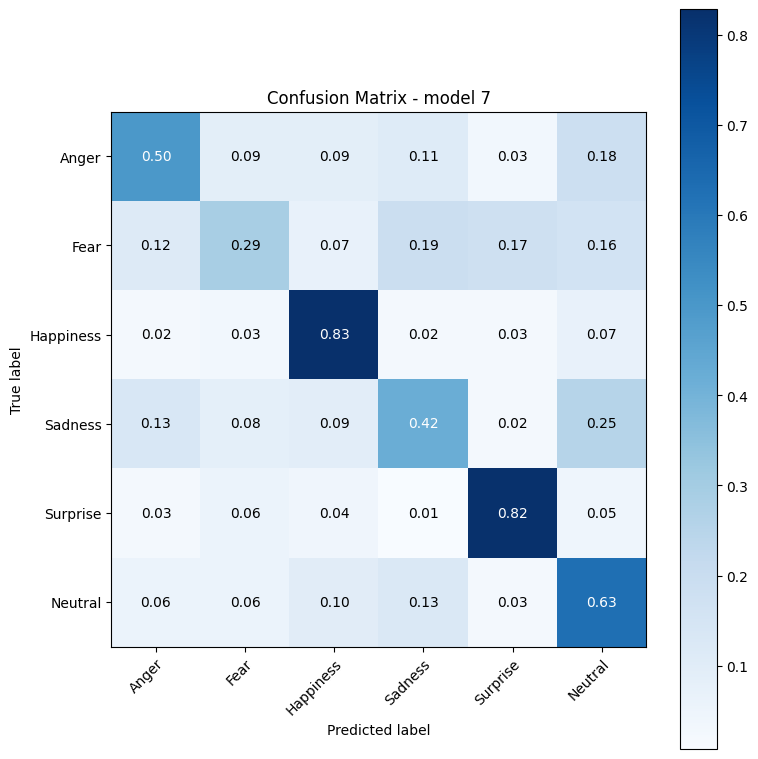

In [344]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels6.argmax(axis=1))
emotion_labels = ['Anger', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

plot_confusion_matrix(conf_mat=conf_mat,
                      class_names=emotion_labels,
                      normalize=True,
                      figsize=(8, 8),
                      title="Confusion Matrix - model 7")

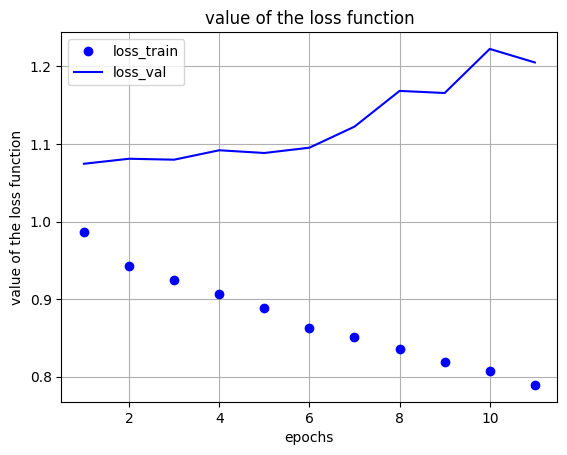

In [347]:
loss = history6.history['loss']
loss_val = history6.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

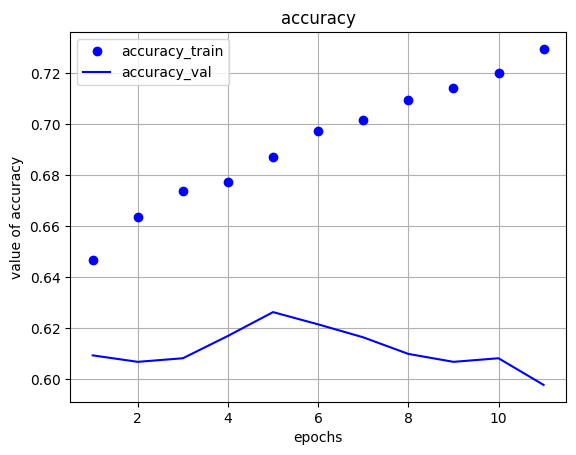

In [348]:
acc = history6.history['accuracy']
acc_val = history6.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

###Test on our own Data set
Since model 5 until now has the best results we will try it on our own data set

### Loading our new Data set

In [349]:
import pandas as pd

# Read the CSV file into a DataFrame
ownset = pd.read_csv(r"/content/drive/My Drive/ANN/flattened_data.csv")



# Get the first 2304 columns
first_2304_columns = ownset.iloc[:, :2304]

# Merge the first 2304 columns into a single column
ownset['Pixels'] = first_2304_columns.apply(lambda row: ','.join(row.values.astype(str)), axis=1)

# Drop the original 2304 columns
ownset.drop(first_2304_columns.columns, axis=1, inplace=True)



In [350]:

# Define the emotions and their corresponding numerical labels
emotion_labels = {
    'Anger': 0,
    'Fear': 1,
    'Happiness': 2,
    'Sadness': 3,
    'Surprise': 4,
    'Neutral': 5
}

# Create a new column with the numerical labels
ownset['Emotion'] = ownset['Label'].map(emotion_labels)
ownset.drop('Label',axis=1, inplace=True)
Emotion = ownset["Emotion"]
ownset.head()

,Pixels,Emotion
0,"86,87,88,86,86,87,88,90,91,92,92,95,95,96,98,9...",0
1,"235,235,234,233,233,232,231,230,228,227,224,22...",0
2,"136,136,136,135,133,136,137,135,137,129,129,13...",0
3,"227,227,228,230,229,230,233,230,231,232,234,23...",0
4,"181,184,185,186,190,192,195,194,195,197,199,20...",0


In [351]:
def prepare_test(ownset):
    image_array = []
    image_label = []

    for _, row in ownset.iterrows():
        pixels = row['Pixels']
        emotion = row['Emotion']

        image = np.array([int(p) for p in pixels.split(',')], dtype=np.uint8)
        image = image.reshape((48, 48))

        image_array.append(image)
        image_label.append(emotion)

    return np.array(image_array), np.array(image_label)


In [352]:
owntest_image_array, owntest_image_label = prepare_test(ownset)


In [353]:
owntest_images = preprocess_images(owntest_image_array)
owntest_labels = to_categorical(owntest_image_label, num_classes=6)


we will test our own set with model number 5 which has a better balanced results on the predicted values

In [355]:

owntest_loss, owntest_acc = model5.evaluate(owntest_images, owntest_labels)
print('test caccuracy:', owntest_acc)


2/2 [==============================] - 0s 9ms/step - loss: 1.3446 - accuracy: 0.5000
test caccuracy: 0.5


In [356]:
pred_owntest_labels = model5.predict(owntest_images)

2/2 [==============================] - 0s 5ms/step


In [357]:
def plot_testimage_and_emotion(owntest_image_array, owntest_image_label, pred_owntest_labels, image_number1):

    emotion_label = { 0:'Anger',
                      1:'Fear',
                      2:'Happiness',
                      3:'Sadness',
                      4:'Surprise',
                      5:'Neutral'
                     }
    # Extract emotion labels and predicted probabilities for the given image number
    emotions = list(emotion_label.values())


    # Plot the predicted labels


    fig1, axs1 = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

    # Plot the image
    axs1[0].imshow(owntest_image_array[image_number1], cmap='gray')
    axs1[0].set_title(emotion_label[owntest_image_label[image_number1]])
    axs1[0].axis('off')

    # Plot the predicted labels
    axs1[1].bar(emotions, pred_owntest_labels[image_number1], color='orange', alpha=0.7)
    axs1[1].set_ylabel('Probability')
    axs1[1].set_title('Predicted Emotion Probabilities')
    axs1[1].grid(axis='y')

    plt.tight_layout()
    plt.show()



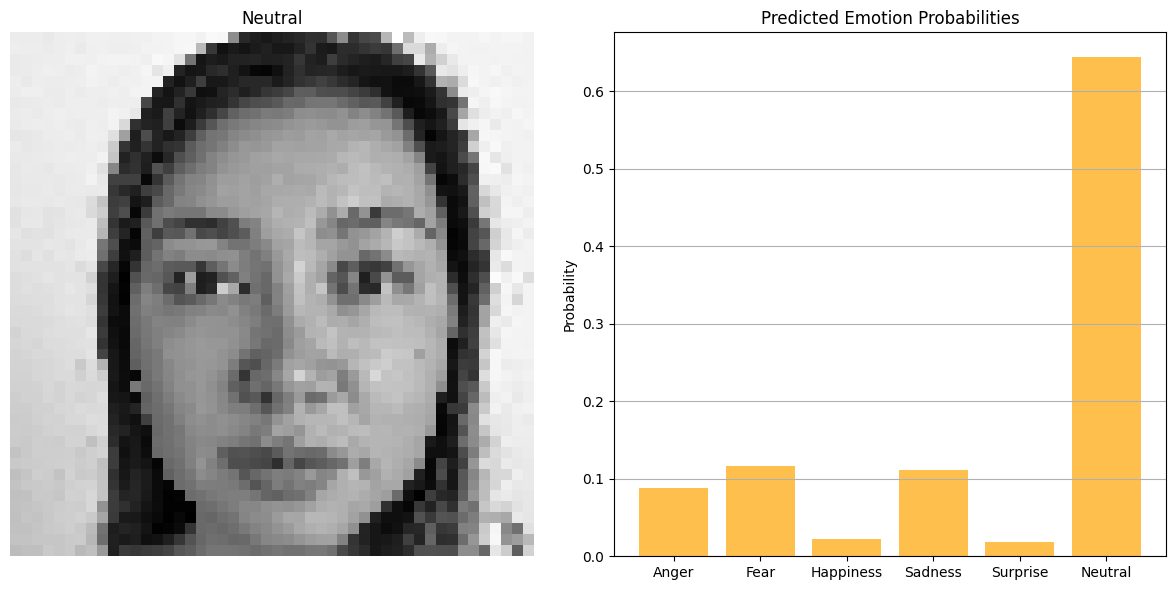

In [358]:
plot_testimage_and_emotion(owntest_image_array, owntest_image_label, pred_owntest_labels, 35)

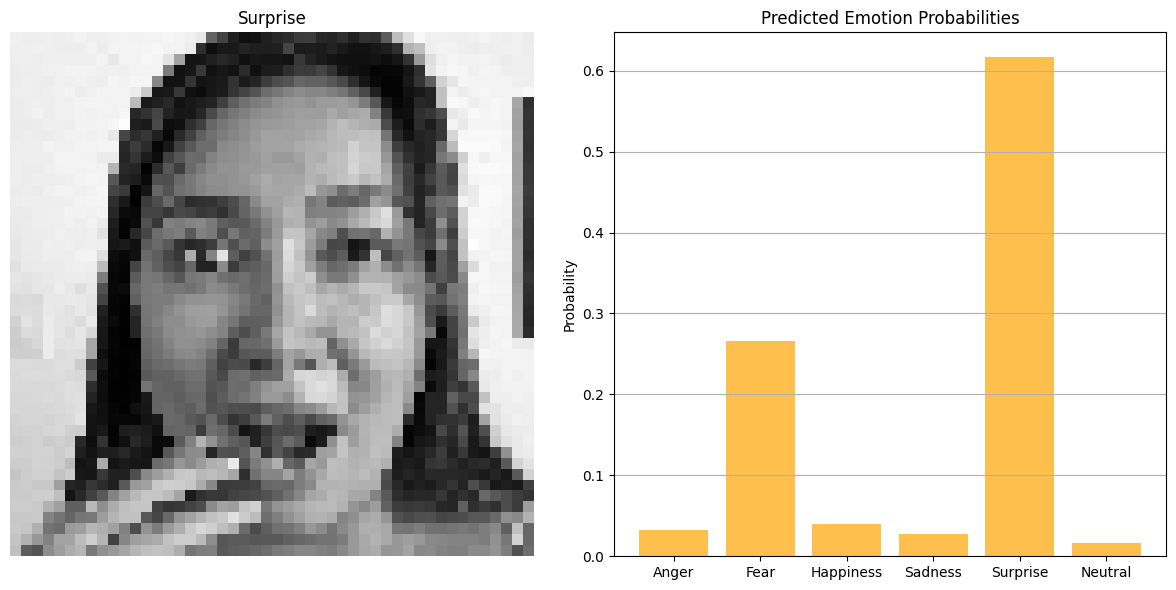

In [360]:
plot_testimage_and_emotion(owntest_image_array, owntest_image_label, pred_owntest_labels, 55)